In [53]:
import cv2
import numpy as np
import torch.cuda
from numpy import asarray
from dataset import Dataset
import timeit
import matplotlib.pyplot as plt
from PIL import Image

from utils import plot_img, box_center2corner, intersection_over_union, iou_per_box, label2char
from detection.handcrafted import Preprocess, DetectChars, DetectPlates, Detect
from recognition.character_based import ctc_decoder

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

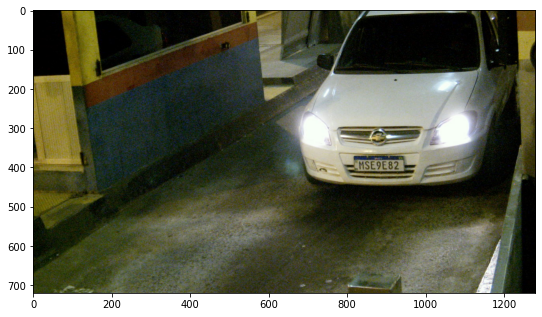

In [88]:
img = cv2.imread('dataset/images/img_010001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, channel = img.shape
plot_img(img)

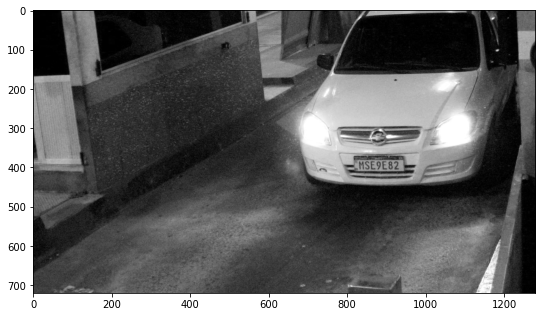

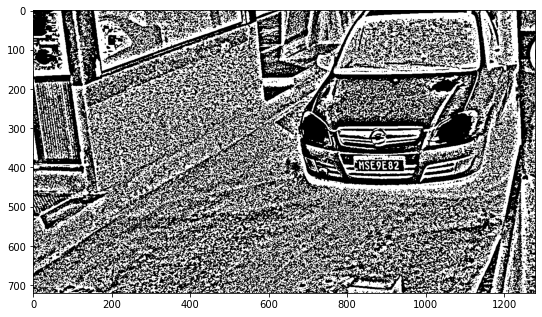

In [89]:
img_gray_scale, img_thresh = Preprocess.preprocess(img, 39, 1)
plot_img(img_gray_scale)
plot_img(img_thresh)

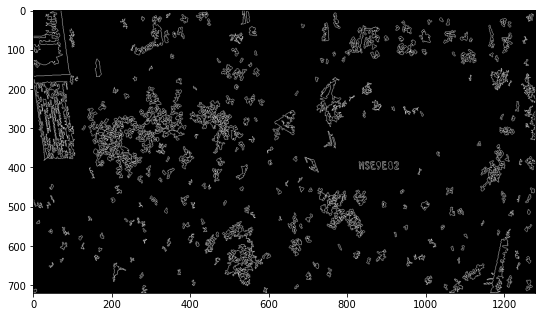

In [90]:
list_possible_chars = DetectPlates.find_possible_chars(img_thresh)
imgContours = np.zeros((height, width, 3), np.uint8)

contours = []

for possibleChar in list_possible_chars:
    contours.append(possibleChar.contour)

cv2.drawContours(imgContours, contours, -1, [255, 255, 255])
plot_img(imgContours)

In [91]:
import random

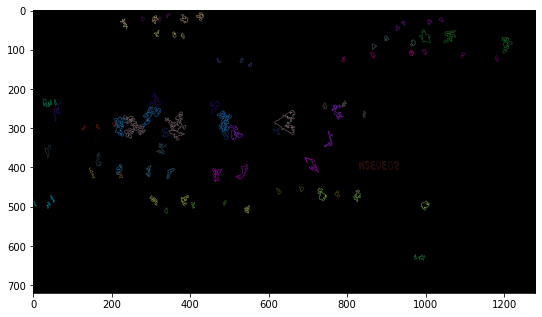

In [92]:
listOfListsOfMatchingCharsInScene = DetectChars.find_list_of_list_matching_chars(list_possible_chars)
imgContours = np.zeros((height, width, 3), np.uint8)

for listOfMatchingChars in listOfListsOfMatchingCharsInScene:
    intRandomBlue = random.randint(0, 255)
    intRandomGreen = random.randint(0, 255)
    intRandomRed = random.randint(0, 255)

    contours = []

    for matchingChar in listOfMatchingChars:
        contours.append(matchingChar.contour)
    # end for

    cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))

plot_img(imgContours)

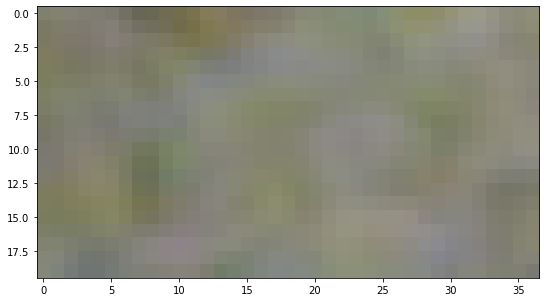

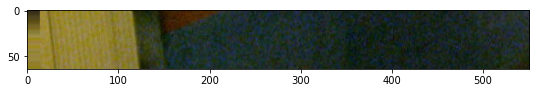

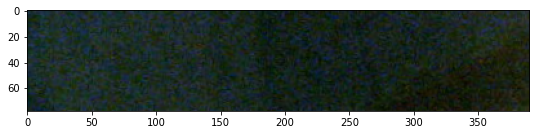

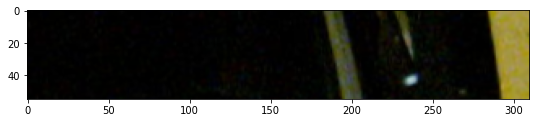

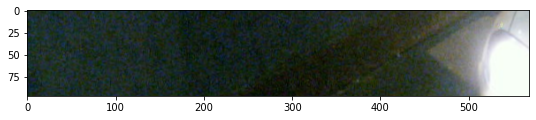

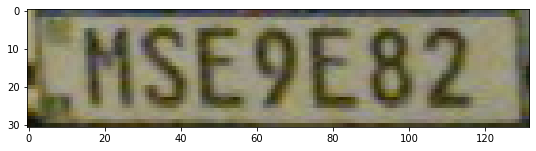

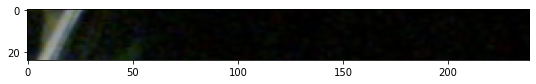

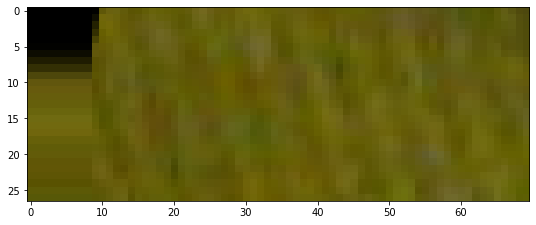

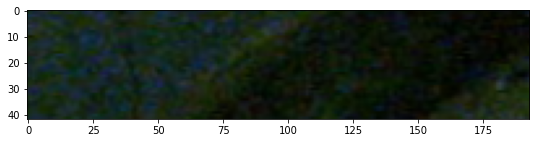

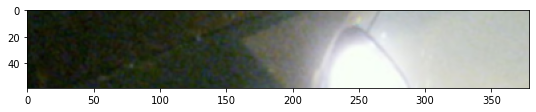

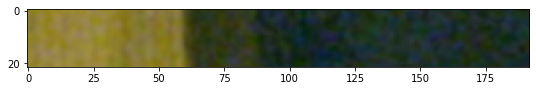

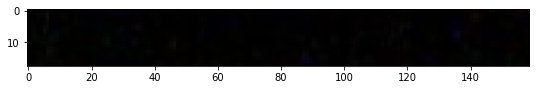

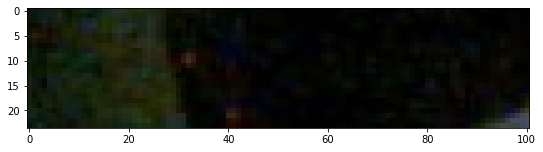

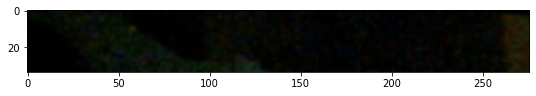

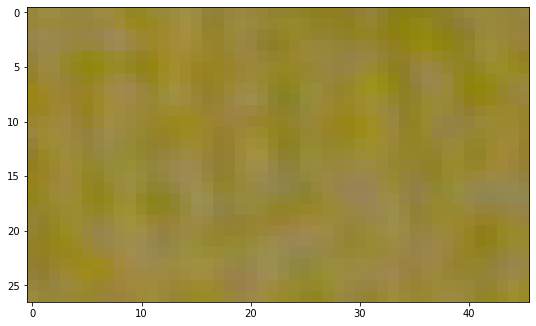

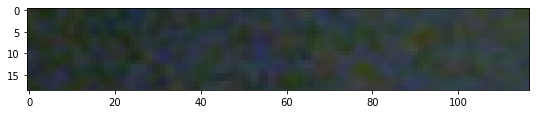

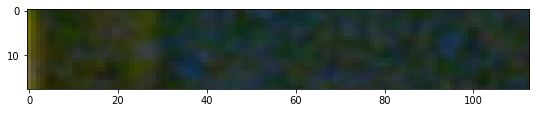

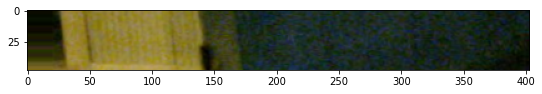

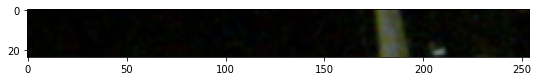

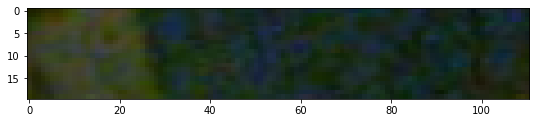

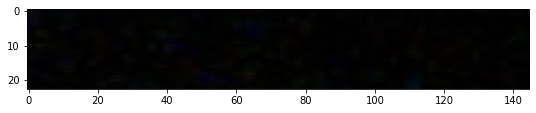

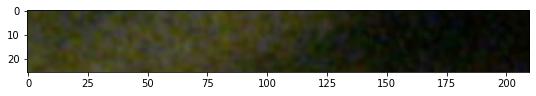

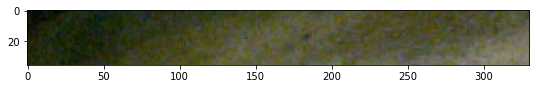

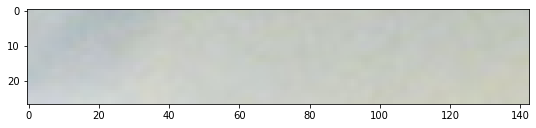

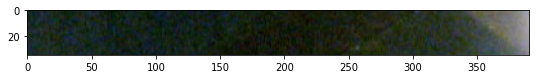

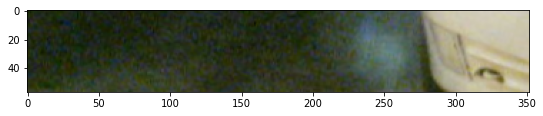

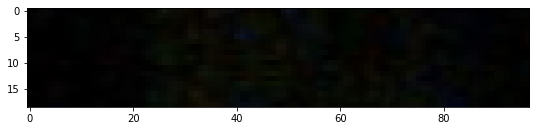

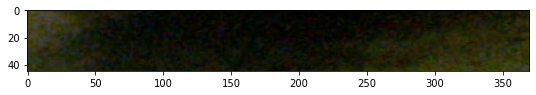

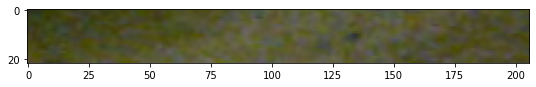

In [93]:
list_possible_plates = []
for list_matching_chars in listOfListsOfMatchingCharsInScene:
    possible_plate = DetectPlates.extract_plate(img, list_matching_chars)
    list_possible_plates.append(possible_plate)

plates = []
if len(list_possible_plates) >= 1:
    for plate in list_possible_plates:
        img_plate = plate.img_plate
        img_plate = cv2.resize(img_plate, (128, 32), interpolation =Image.BILINEAR)
        img_plate = np.array(img_plate)
        img_plate = cv2.cvtColor(img_plate, cv2.COLOR_RGB2GRAY)
        img_plate = (img_plate / 127.5) - 1.0
        img_plate = torch.FloatTensor(img_plate).unsqueeze(0)
        plates.append(img_plate)

        plot_img(plate.img_plate)

# Character based

In [94]:
crnn = model.CRNN(1, 32, 128, 37).to(device)
checkpoint_path = 'checkpoint/crnn.pt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
crnn.load_state_dict(checkpoint)

for plate_img in plates:
    logits = crnn(plate_img.unsqueeze(0).to(device))
    log_probs = torch.nn.functional.log_softmax(logits, dim=2)
    preds = ctc_decoder.ctc_decode(log_probs, method='beam_search', beam_size=10)
    preds_str = label2char(preds)
    print("predict plate:", preds_str[0])

AttributeError: module 'recognition.segment_based.model' has no attribute 'CRNN'

# Segment based

In [ ]:
from recognition.segment_based import segment_character, evaluate, model

model1 = model.Segment_character(36).to(device)
checkpoint_path = 'checkpoint/character_model.pt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
model1.load_state_dict(checkpoint)

plates = []
if len(list_possible_plates) >= 1:
    for plate in list_possible_plates:
        img_plate = plate.img_plate
        plates.append(img_plate)

for img in plates:
    img = np.array(img, dtype='uint8')
    chars = segment_character.segment_characters(img)
    for j in range(len(chars)):
        plt.subplot(1, len(chars) + 1, j + 1)
        plt.imshow(chars[j], cmap='gray')
        plt.axis('off')
    plt.show()


    pred_str = [evaluate.show_results(chars, model1)]
    print("predict plate:", pred_str[0])

In [ ]:
def end2end_character_based(img): # RGB image
    ####################---DETECTION---##########################
    list_possible_plate1 = DetectPlates.detect_plates(img, 19, 9)
    list_possible_plate2 = DetectPlates.detect_plates(img, 39, 1)
    list_possible_plate = Detect.remove_overlapping_plate(list_possible_plate1, list_possible_plate2)
    plates = []

    for plate in list_possible_plate:
        img_plate = plate.img_plate
        img_plate = cv2.resize(img_plate, (128, 32), interpolation =Image.BILINEAR)
        img_plate = np.array(img_plate)
        img_plate = cv2.cvtColor(img_plate, cv2.COLOR_RGB2GRAY)
        img_plate = (img_plate / 127.5) - 1.0
        img_plate = torch.FloatTensor(img_plate).unsqueeze(0)
        plates.append(img_plate)

    ####################---RECOGNITION---##########################
    crnn = model.CRNN(1, 32, 128, 37).to(device)
    checkpoint_path = 'checkpoint/crnn.pt'
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    crnn.load_state_dict(checkpoint)


    for plate_img in plates:
        logits = crnn(plate_img.unsqueeze(0).to(device))
        log_probs = torch.nn.functional.log_softmax(logits, dim=2)
        preds = ctc_decoder.ctc_decode(log_probs, method='beam_search', beam_size=10)
        preds_str = label2char(preds)
        print("predict plate:", preds_str[0])

end2end_character_based(img)

In [ ]:
def end2end_segment_based(img): # RGB image
    ####################---DETECTION---##########################
    list_possible_plate1 = DetectPlates.detect_plates(img, 19, 9)
    list_possible_plate2 = DetectPlates.detect_plates(img, 39, 1)
    list_possible_plate = Detect.remove_overlapping_plate(list_possible_plate1, list_possible_plate2)

    plates = []
    for plate in list_possible_plate:
        img_plate = plate.img_plate
        plates.append(img_plate)

    ####################---RECOGNITION---##########################

    for img in plates:
        img = np.array(img, dtype='uint8')
        chars = segment_character.segment_characters(img)
        for j in range(len(chars)):
            plt.subplot(1, len(chars) + 1, j + 1)
            plt.imshow(chars[j], cmap='gray')
            plt.axis('off')
        plt.show()

        pred_str = [evaluate.show_results(chars, model1)]
        print("predict plate:", pred_str[0])

end2end_segment_based(img)